In [2]:
!pip install pygame

     |████████████████████████████████| 21.8 MB 1.2 MB/s eta 0:00:01


## Experimento Tiempo de Reacción con PyGame

Esta notebook implementa un sencillo experimento de Tiempo de Reacción con PyGame, mide los resultados y devuelve gráficos y estadísticos.

**No anda en Colab**!

In [2]:
# libreria para GUI
import pygame
# para funciones random
import numpy as np 
# plotear
import matplotlib.pyplot as plt
# config en jupyter
%matplotlib inline
import seaborn as sns
# para sonidito
from IPython.display import Audio, display, clear_output
# para ocultar mensajes feos
import warnings
warnings.filterwarnings("ignore")

pygame 2.1.2 (SDL 2.0.16, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class Experimento(object):
    def __init__(self, n_trials=10, backgr = (212, 212, 212), font='Verdana', font_size=23,
          instr='Presione una tecla.', off_mean=0, off_std=0, tempo = 100, beep = False):
        self.self = self
        self.n_trials = n_trials
        self.instructions = instr.split("\n")
        self.tempo = tempo
        self.beep = beep
        self.off_mean, self.off_std = off_mean, off_std
        self.t_stimuli, self.t_responses = [], []
        self.backgr = backgr
        self.font, self.font_size = font, font_size
        self.name = 'Diego :D'

    @staticmethod
    def play_beep(f=440, s=0.1, A = 1):
        framerate = 44100
        t = np.linspace(0,s,int(framerate*s))
        d = A * np.cos(2*np.pi*f*t)
        display(Audio(d, rate=44100, autoplay = True))    

    def instruct(self):
        # Funcion para dar instrucciones y promptear al sujeto
        count = 1
        for inst in self.instructions:
            instruction = self.font.render(inst, 1, (0, 0, 0))
            # count multiplica la coord para que no se pisen
            self.buffer.blit(instruction, ((self.width/2) - (instruction.get_rect().width/2),
                                  (100 + (instruction.get_rect().height+10)*count)))
            count += 1 

        pygame.display.flip()

        start = False
        while not start:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        pygame.quit()
                        exit()
                    else:
                        start = True
                        break
                        
    def fixate(self, ms):
        """Genera punto de fijacion y guarda respuestas pre-estimulo"""
        # tapa instrucciones
        self.buffer.fill(self.backgr)

        # dibuja fixation point
        pygame.draw.line(self.buffer, (0, 0, 0), (self.width/2, self.height/2 - 20), (self.width/2, self.height/2 + 20), 2)    
        pygame.draw.line(self.buffer, (0, 0, 0), (self.width/2 - 20, self.height/2), (self.width/2 + 20, self.height/2), 2)    
        
        pygame.display.flip()
        t0 = pygame.time.get_ticks()
        pressed = False
        while pygame.time.get_ticks() < t0 + ms:
            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        pygame.quit()
                        exit()
                    else:
                        self.t_responses.append(pygame.time.get_ticks())
                        pressed = True
        return pressed
    
    def rhythm_TR(self):
        # Toma prueba de reaccion ritmica
        duracion_stim_ms = 150
        for _ in range(self.n_trials): 
            # espera el tiempo en ms correspondiente al tempo
            off = np.random.normal(self.off_mean, self.off_std)
            t = int((60/self.tempo) * 1000) + int(off)

            pressed = self.fixate(t)
            
            # guardamos los tiempos en la lista de estimulos
            self.t_stimuli.append(pygame.time.get_ticks())
            
            # muestra el circulo
            pygame.draw.circle(self.buffer, (255, 0, 0), (int(self.width/2), int(self.height/2)), 200)
            pygame.display.flip()
            if self.beep:
                self.play_beep()
                clear_output()
            
            #si se anticipo, salteamos al prox
            if pressed:
                continue
            
            t0 = pygame.time.get_ticks()
            running = True        
            while pygame.time.get_ticks() < t0 + duracion_stim_ms:
                for event in pygame.event.get():
                    if event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            pygame.quit()
                            exit()
                        else:
                            self.t_responses.append(pygame.time.get_ticks())
                            # Para pasar prox trial
                            running = False
    
    def run(self):
        # corre el experimento
        pygame.init()
        self.font =  pygame.font.SysFont(self.font, self.font_size)
        self.width, self.height = pygame.display.Info().current_w, pygame.display.Info().current_h
        self.buffer = pygame.display.set_mode((self.width, self.height), pygame.FULLSCREEN)
        # color de fondo
        self.buffer.fill(self.backgr)
        pygame.display.flip()
        # nombre de ventana
        pygame.display.set_caption(self.name)
        self.instruct()
        self.rhythm_TR()
        pygame.quit()
    
    def clean_data(self):
        # Me quedo con la respuesta más cercana a cada estímulo
        # para cada tiempo de estimulo, me quedo con el tiempo de respuesta que tenga la diferencia absoluta minima
        r = []
        for s in self.t_stimuli:
            closest = self.t_responses[np.argmin([abs(s-r) for r in self.t_responses])]
            err = closest - s
            if abs(err) > 0.5*(60/self.tempo)*1000:
                print('No response for stim {}'.format(self.t_stimuli.index(s)))
                del s
            else:
                r.append(closest)
        
    
    def get_data(self):
        return self.t_stimuli, self.t_responses
    
    def plot_data(self):
        errs = [(r-s) for s,r in zip(self.t_stimuli, self.t_responses)]
        fig, ax = plt.subplots(1,2, figsize=(11,4))
        ax[0].plot(errs);
        ax[0].set_ylabel('Error (ms)')
        ax[0].set_xlabel('Trials (tr)')
        sns.distplot(errs, ax=ax[1])
        ax[1].set_ylabel('Frequencia')
        ax[1].yaxis.set_label_position("right")
        ax[1].set_xlabel('Error (ms)')
        plt.show()

In [3]:
instr = "Aparecerá un círculo rojo en pantalla. Presione una tecla apenas lo vea. \n Presione ENTER para comenzar."

exp = Experimento(instr=instr, n_trials=40, tempo=80, beep=True)

In [5]:
#exp.t_stimuli = stim
#exp.t_responses = resp

In [ ]:
#%%capture
exp.run()

In [ ]:
exp.clean_data()

In [34]:
stim, resp = exp.get_data()
len(stim), len(resp)

(40, 44)

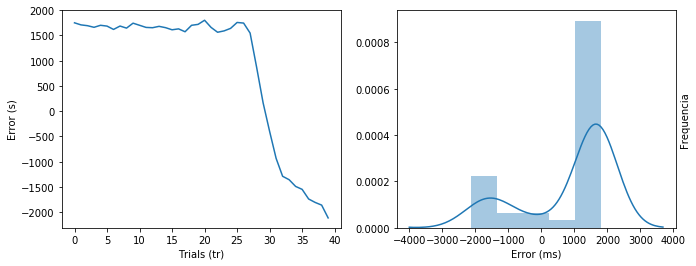

In [37]:
exp.plot_data()